# Postnord data science project assignment

##  Postnord Data Science technical assignment

In Postnord we want to predict how many parcels (packages) arrive daily at each of our buildings (terminals and distribution hubs). In this assignment you'll have to develop a machine learning model similar to the one we have for a specific building.

On a daily basis, we are predicting how many parcels will arrive at each of our buildings over the next 30 days. So, today, we'll use our model for predicting the next 30 days. We're providing a train set with historical data, and a test set containing the next 30 days after the training set. So, you'll have to develop a validation strategy in order to train and validate your model aiming to provide the best generalization, and then you'll test your solution on the test set. 

For evaluating your model, we'll use Mean Squared Error, focusing only on 1 day ahead time horizon. This means that you should always use data which would be available up to the previous day. So, the final test set should be evaluated like this:
- 2021-06-01 -> You can use data up to 2021-05-31
- 2021-06-02 -> You can use data up to 2021-06-01
- 2021-06-03 -> You can use data up to 2021-06-02
- ... 2021-06-30 -> You can use data up to 2021-06-29

Finally, just apply a simple average over all the MSEs you got from proceeding as said before so as to get the final performance metric.

Format
- Use Python. It's our main language and we don't work with R or any other.
- Prepare a Jupyter notebook with all your work. The structure could be something like EDA, Modeling and Conclusions, but you have freedom to choose your own sections. Write some text/comments along with your code so as to explain why you did something or what you found interesting for example when inspecting the dataset.

Hints
- We'll be mainly focusing on how you approach the problem. You're working with time series data, so you'll need an appropriate validation strategy (be careful with issues such as lookahead bias). Always have in mind that this model should work in a production environment, on any given date.
- We'll also evaluate your ability to handle time-series data using Pandas library.
- Try 2-3 different machine learning algorithms which can be relevant on this task. Don't waste time on trying all of them.
- You can run some minor hyperparameter optimization process, but don't waste your time looking for the best score. 
- If you find something challenging, don't waste too much time on it. Explain why it was challenging and how you could tackle it in case you had more time.


# Data preparation

## Import usefull libraries for this project

In [1]:
# For data loading and preprocessing
import numpy as np
import pandas as pd
from pandas import read_csv,to_datetime,DataFrame
# Model and metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

__Data loading__

In [2]:
# Load train data
train = pd.read_pickle("train.pkl")
train.head()

date
2016-01-01         0
2016-01-02         0
2016-01-03     43653
2016-01-04    317923
2016-01-05    288444
Name: 705, dtype: int64

In [3]:
train.tail()

date
2021-05-27    246933
2021-05-28    202650
2021-05-29         0
2021-05-30     69092
2021-05-31    278579
Name: 705, dtype: int64

In [4]:
# Test data
test = pd.read_pickle("test.pkl")
test.head()

date
2021-06-01    263006
2021-06-02    251397
2021-06-03    272852
2021-06-04    202058
2021-06-05         0
Name: 705, dtype: int64

In [5]:
# Copy the data to keep in original
train_original = train.copy()
train_original = train_original.reset_index()
train_original.columns = ["date", "parcels_rcv"]
test_original = test.copy()
test_original = test_original.reset_index()
test_original.columns = ["date", "parcels_rcv"]

## Converting train and test dataset into dataframe

In [6]:
train = train.reset_index()
train.columns = ["date", "parcels_rcv"]
train.head()

,date,parcels_rcv
0,2016-01-01,0
1,2016-01-02,0
2,2016-01-03,43653
3,2016-01-04,317923
4,2016-01-05,288444


In [7]:
test = test.reset_index()
test.columns = ["date", "parcels_rcv"]
test.head()

,date,parcels_rcv
0,2021-06-01,263006
1,2021-06-02,251397
2,2021-06-03,272852
3,2021-06-04,202058
4,2021-06-05,0


## Look at the data types

In [8]:
train.dtypes, test.dtypes

(date           datetime64[ns]
 parcels_rcv             int64
 dtype: object,
 date           datetime64[ns]
 parcels_rcv             int64
 dtype: object)

In [9]:
train.shape, test.shape

((1978, 2), (30, 2))

# Feature extraction

Now we will extract more features to validate our hypothesis. we will have extract time and date from the datetime.

WE made hypothesis as 
- parcel count will increase as the years pass by.
- parcel count will increase from sept to dec month.
- parcel on weekdays will be more as weekend is off.
After having a look at the dataset, we will now try to validate our hypothesis and make other inferences from the dataset.

But first we have to change the datatype to datetime format from object to extract datetime.

In [10]:
train["date"] = pd.to_datetime(train.date, format = "%d-%m-%Y")
test["date"] = pd.to_datetime(test.date, format = "%d-%m-%Y")
train_original["date"] = pd.to_datetime(train_original.date, format = "%d-%m-%Y")
test_original["date"] = pd.to_datetime(test_original.date, format = "%d-%m-%Y")

We made some hypothesis for the effect of hour, day, month and year on parcel count. Lets extract the day, month and year from datetime to validate our hypothesis.

In [11]:
for i in (train, test, train_original, test_original):
    i["year"] = i.date.dt.year
    i["month"] = i.date.dt.month
    i["day"] = i.date.dt.day
    i["hour"] = i.date.dt.hour
        

We made a hypothesis for the parcel count pattern on weekdays and weekend as well. So lets make weekend variable to visualize the impact of weekend on parcel count.
- We will first extract the day of week from date and then based on the values we will assign whether the day is a weekend or not.
- values of 5 and 6 represents that the days are weekend.

In [12]:
train["day_of_week"] = train["date"].dt.dayofweek
temp = train["date"]

In [44]:
# Lets assign 1 if the day of week is weekend and 0 if the day of week is not weekend.
def applyer(row):
    if row.dayofweek >=5:
        return 1
    else:
        return 0
temp2 = train["date"].apply(applyer)
train["weekend"] = temp2

In [14]:
train.head()

,date,parcels_rcv,year,month,day,hour,day_of_week,weekend
0,2016-01-01,0,2016,1,1,0,4,0
1,2016-01-02,0,2016,1,2,0,5,1
2,2016-01-03,43653,2016,1,3,0,6,1
3,2016-01-04,317923,2016,1,4,0,0,0
4,2016-01-05,288444,2016,1,5,0,1,0


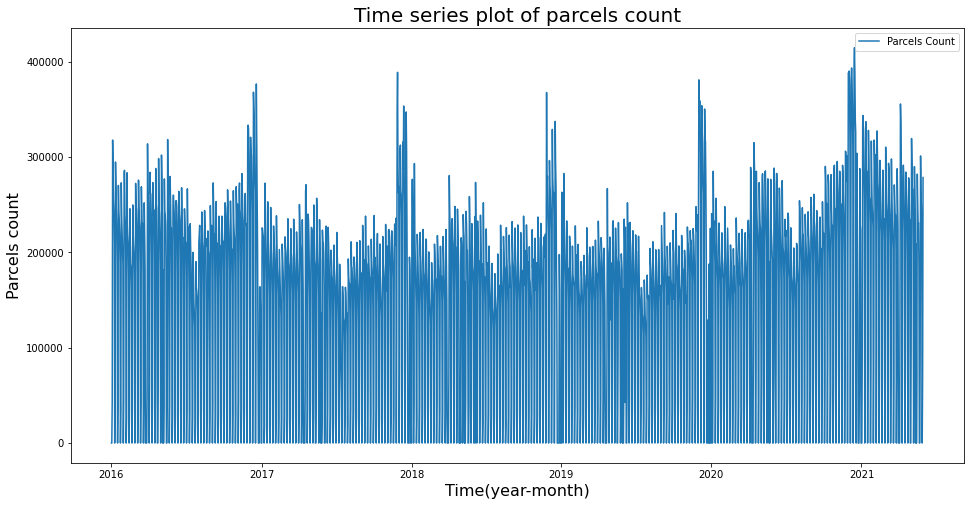

In [48]:
# Lets look at the time series
train.index = train["date"] # indexing the datetime to get the time period on the x-axis.
ts = train["parcels_rcv"]
plt.figure(figsize = (16,8))
plt.plot(ts,label = "Parcels Count")
plt.title("Time series plot of parcels count", fontsize = 20)
plt.xlabel("Time(year-month)", fontsize = 16)
plt.ylabel("Parcels count", fontsize = 16)
plt.legend(loc = "best");


Here we can infer that there is an increasing and decreasing trend in the series, i.e., the number of parcel is increasing with respect of time. we can also see that at certain points there is a sudden increase in the number of counts. the possible reason behind this could be that on particular day, due to some event the traffic was high.

We will work on the train file for all the analysis and we will use the test file for forcasting. 

# Exploratory Analysis
Let us try to verify our hypothesis using actual data.
First hypothesis was parcel count will increase over years pass by. 
Let's look-

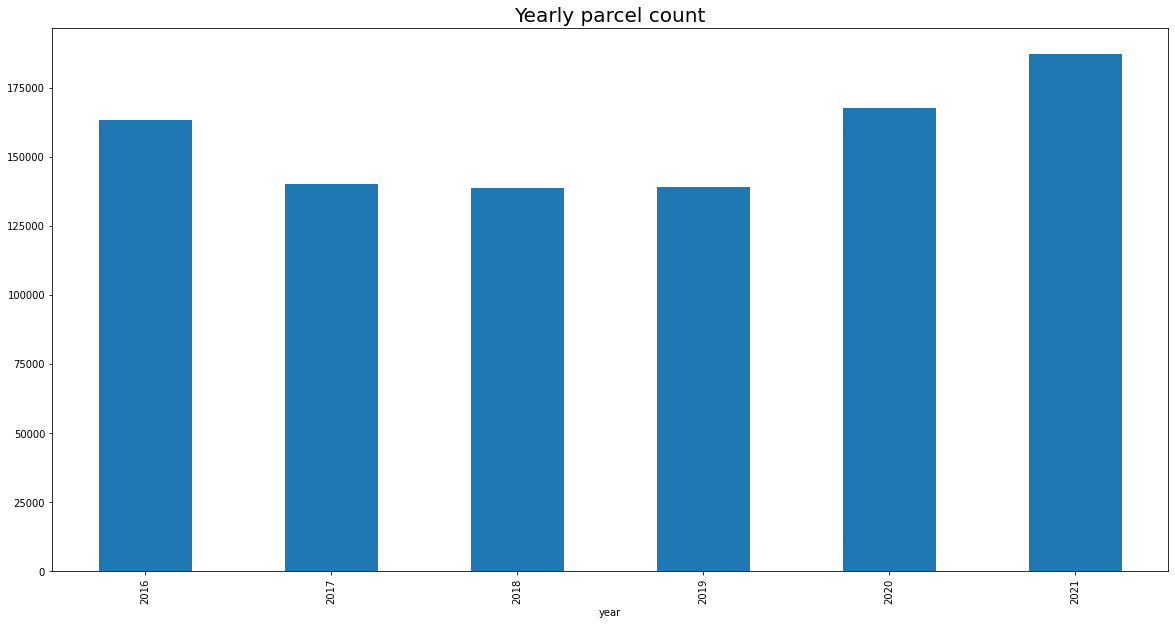

In [50]:
plt.title("Yearly parcel count", fontsize = 20)
train.groupby("year")["parcels_rcv"].mean().plot.bar();

We can see the exponentiaal growth in the parcel count with respect to year which validate our hypothesis.

In [17]:
train.describe()

,parcels_rcv,year,month,day,hour,day_of_week,weekend
count,1978.000000,1978.000000,1978.000000,1978.000000,1978.0,1978.000000,1978.000000
mean,152628.015167,2018.229019,6.253286,15.726491,0.0,3.001517,0.286148
std,99367.759370,1.576454,3.466591,8.800752,0.0,2.001390,0.452074
min,0.000000,2016.000000,1.000000,1.000000,0.0,0.000000,0.000000
25%,40693.000000,2017.000000,3.000000,8.000000,0.0,1.000000,0.000000
50%,180628.500000,2018.000000,6.000000,16.000000,0.0,3.000000,0.000000
75%,223495.000000,2020.000000,9.000000,23.000000,0.0,5.000000,1.000000
max,414802.000000,2021.000000,12.000000,31.000000,0.0,6.000000,1.000000


<IPython.core.display.Javascript object>

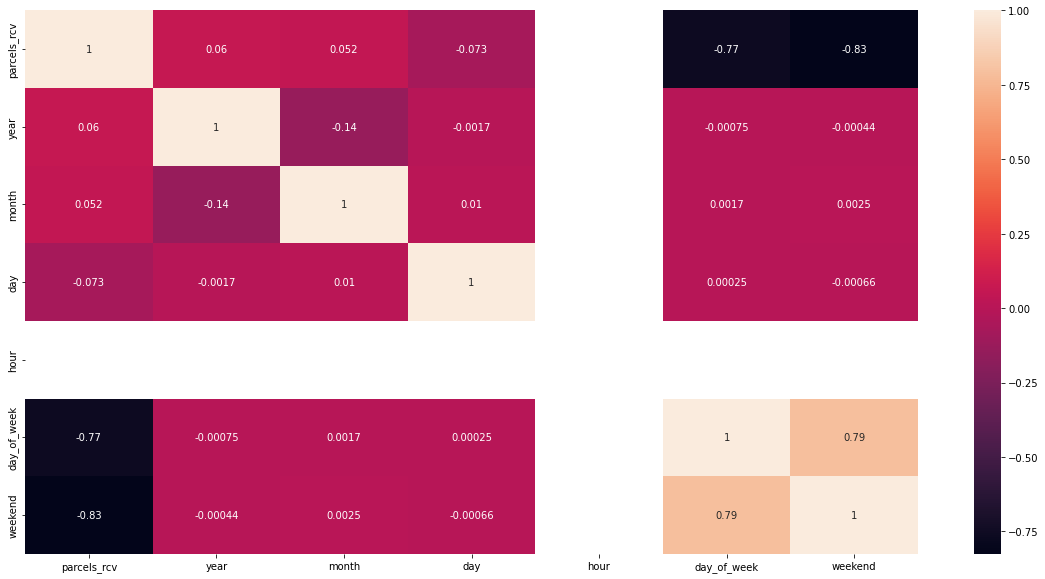

In [18]:
sns.heatmap(train.corr(), annot = True);

Our second hypothesis was about the increase traffic from month of Sept to Dec. so, lets see

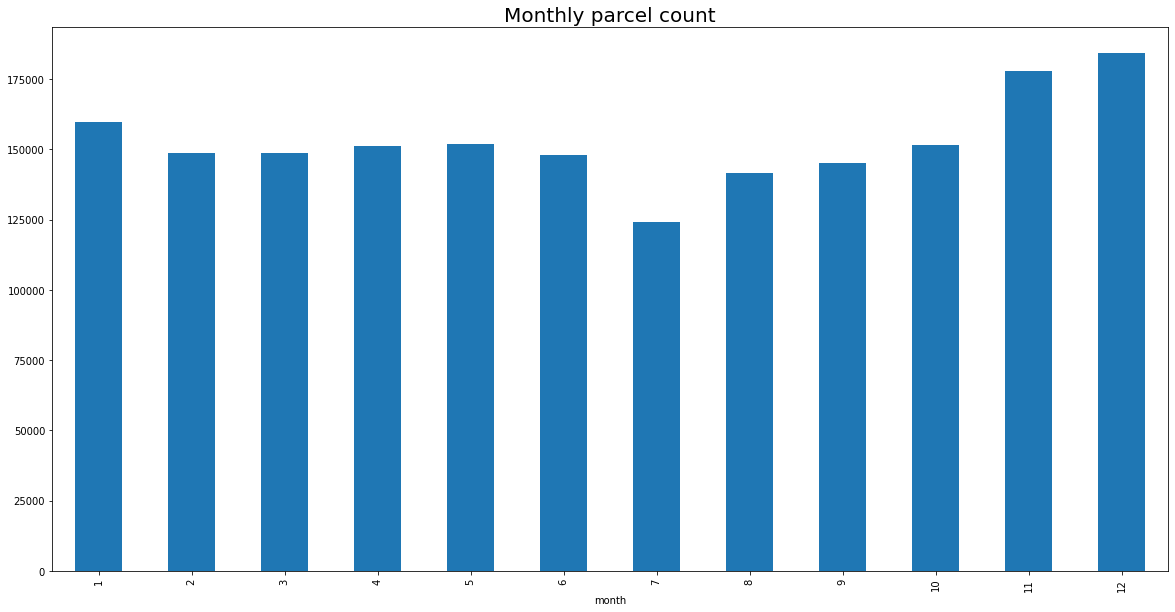

In [51]:
plt.title("Monthly parcel count", fontsize = 20)
train.groupby("month")["parcels_rcv"].mean().plot.bar();

Here we see a decrease in the mean of parcel count in july month becasue may be due summer holiday. 

Lets look at the monthly mean of each year separately.

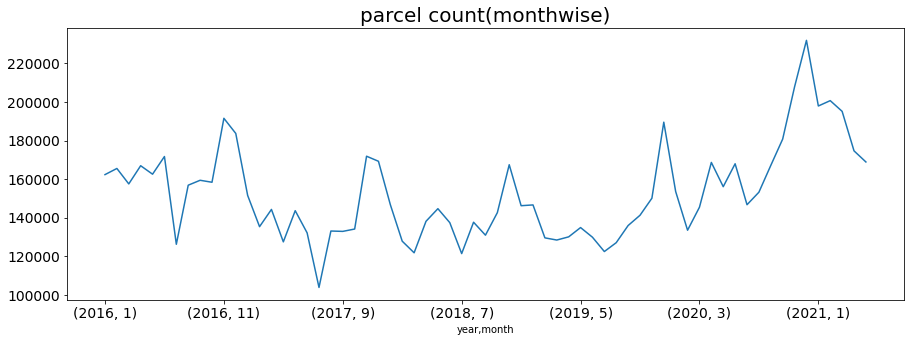

In [53]:
plt.title("parcel count(monthwise)", fontsize = 20)
temp = train.groupby(["year", "month"])["parcels_rcv"].mean()
temp.plot(figsize =(15,5), fontsize = 14);

- We see that the mean value for the year 2017 is very less compare to 2021.
- Since there is increasing trends in our time series, the mean value for rest of the months will be more because of their larger parcel counts in year 2021 in the month of january.
- in the above line plot we can see a slow increasing trend in monthly parcel count and growth is approximately exponential.

Lets look at the daily mean of parcel count

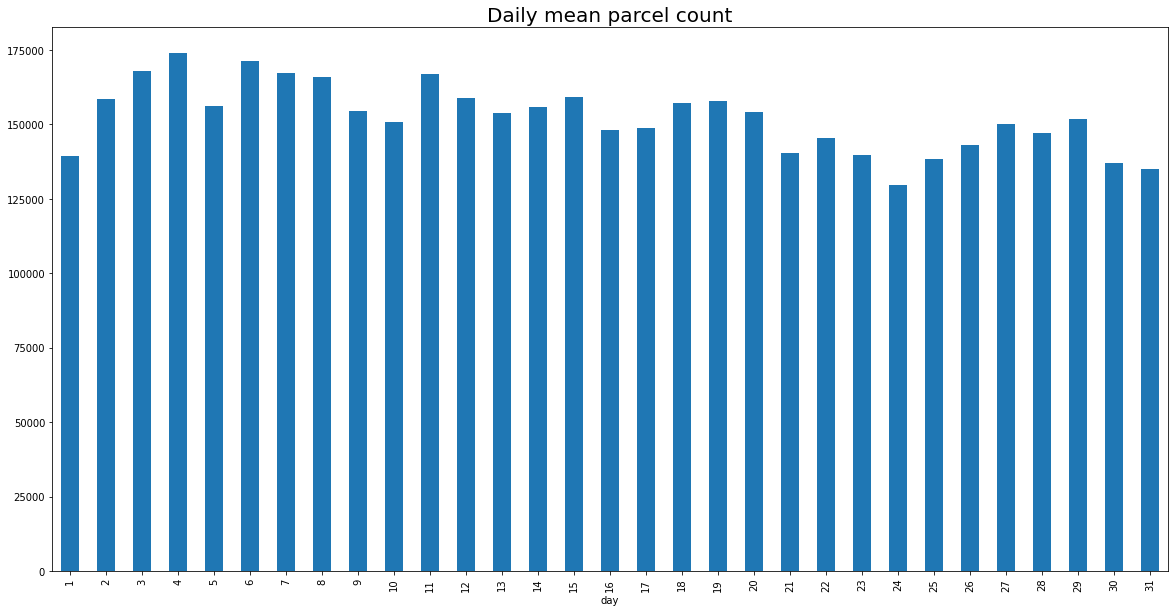

In [55]:
plt.title("Daily mean parcel count", fontsize = 20)
train.groupby("day")["parcels_rcv"].mean().plot.bar();

We are not getting much insights from the day wise count of the parcels.

Lets try to validate our hypothesis in which we assumed that the parcel count will be more on weekdays.

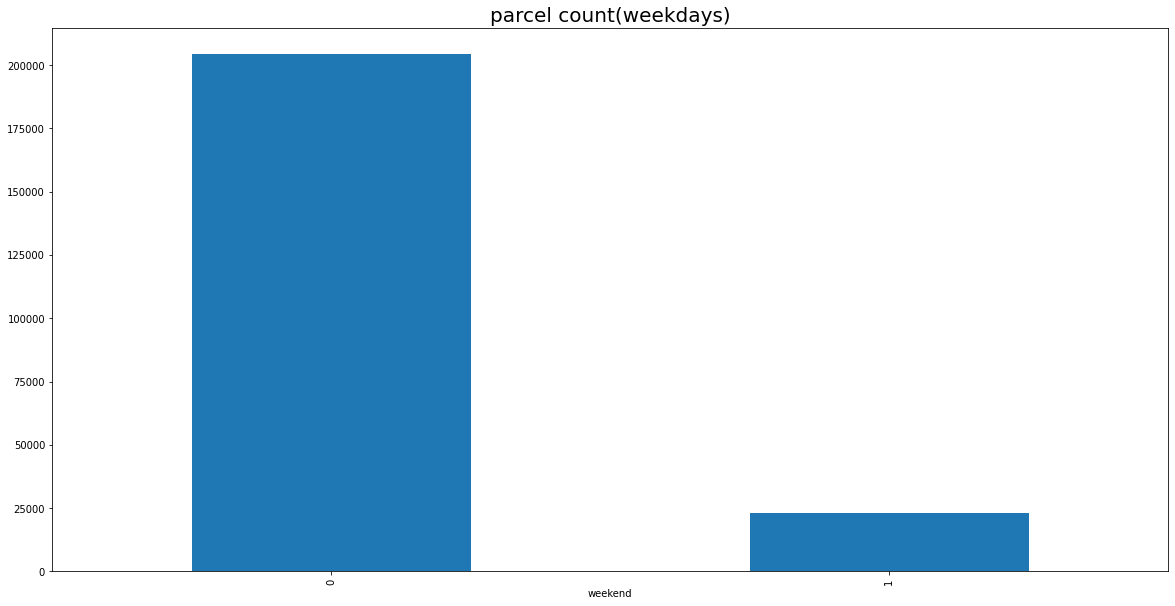

In [56]:
plt.title("parcel count(weekdays)", fontsize = 20)
train.groupby("weekend")["parcels_rcv"].mean().plot.bar();

It can be inferred from the above plot that the traffic is more on weekdays as compared to weekends which validaate our hypothesis.

Now we will try to look at the day wise parcels count.
__Note__-0 is the staring of the week,i.e., 0 is monday and 6 is sunday.

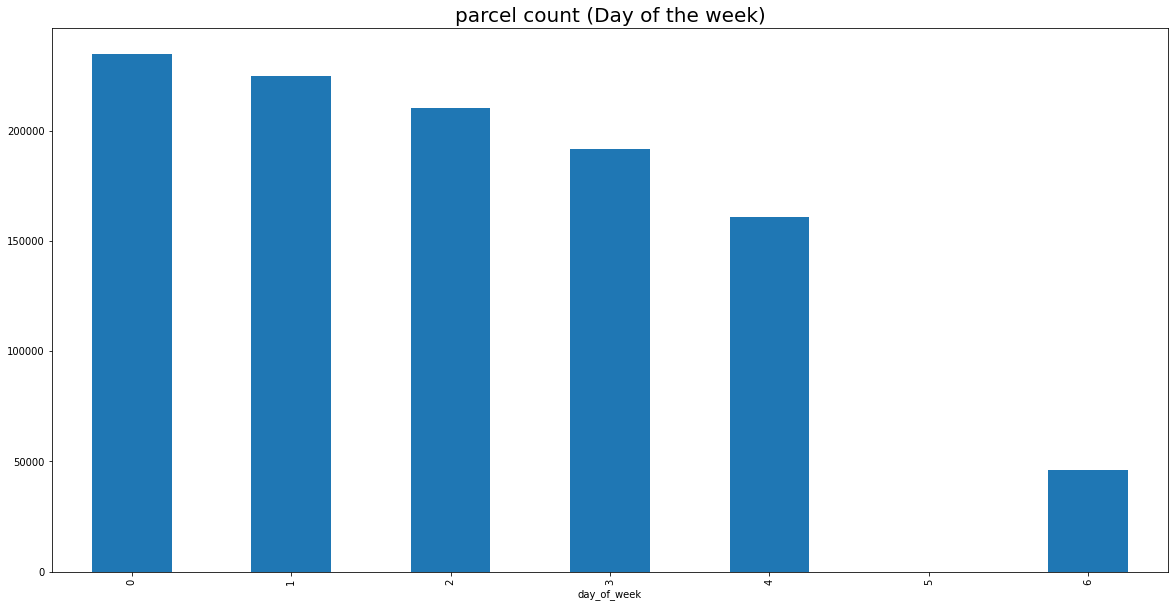

In [58]:
plt.title("parcel count (Day of the week)", fontsize = 20)
train.groupby("day_of_week")["parcels_rcv"].mean().plot.bar();

From the above plot , we can infer that parcel count is less for sturday and sunday compare to the other days of the week. 

As we have seen that there is a lot of variance in the hourly time series, we will aggregate the hourly time series to daily, weekly and monthly time series to reduce the variance and make it more stable and hence would be easier for a model to learn.

__First we look at the means of daily, weekly and monthly parcel count__

In [24]:
train.Timestamp = pd.to_datetime(train.date, format = "%d-%m-%Y")
train.index = train.Timestamp

# converting to daily mean
daily = train.resample("D").mean()

# converting to weekly mean
weekly = train.resample("W").mean()

# converting to monthly mean
monthly = train.resample("M").mean()

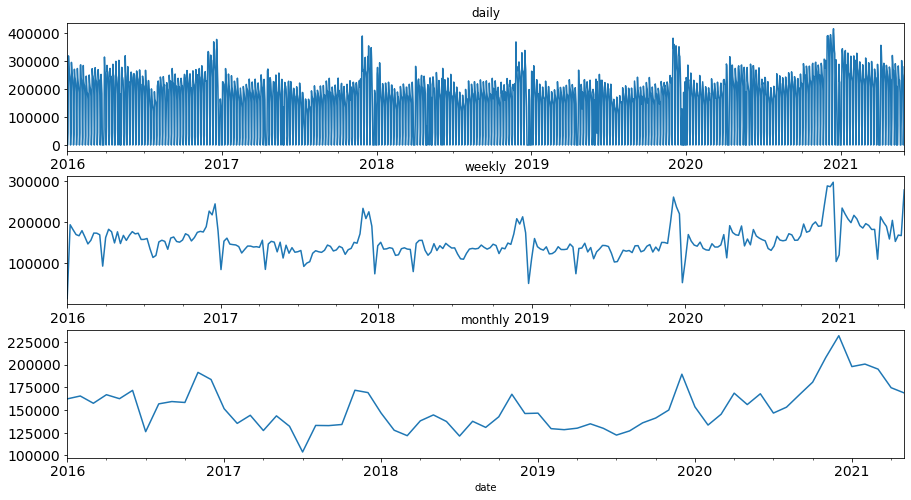

In [25]:
# lets look at the daily, weekly and monthly time series

fig,axs = plt.subplots(3,1)
daily.parcels_rcv.plot(figsize =(15,8), title = "Daily", fontsize =14, ax =axs[0])
weekly.parcels_rcv.plot(figsize =(15,8), title = "Weekly", fontsize =14, ax =axs[1])
monthly.parcels_rcv.plot(figsize =(15,8), title = "Monthly", fontsize =14, ax =axs[2])
plt.show();

We can see that time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

In [26]:
test.Timestamp = pd.to_datetime(test.date, format = "%d-%m-%Y")
test.index = test.Timestamp

# Converting to daily mean
test = test.resample("D").mean()
test.head()

,parcels_rcv,year,month,day,hour
date,,,,,
2021-06-01,263006,2021,6,1,0
2021-06-02,251397,2021,6,2,0
2021-06-03,272852,2021,6,3,0
2021-06-04,202058,2021,6,4,0
2021-06-05,0,2021,6,5,0


As we have validated all our hypothesis, lets go for model building for time series forecasting.

But before we do that we will need a dataset(validation)to check the performance and generalization ability of our model. 

Below are some of properties of the dataset required for the purpose.
- The dataset should have true values of the dependent variable against which the predictions can be checked. Therefore, test dataset cannot be used for the purpose.
- The model should be trained on the validation dataset. Hence we cannot train the model on the train dataset and validate on it as well.

So, for for the above two reasons, we generally divide the train dataset into two parts.

- One part is used to train the model and other part is used as the validation dataset.

There are multiple methods to divide the train dataset such as random division etc. 

We will use for this task time based split method.
- 1) Splitting the data into training and validation part

Now we will divide our data in train and validation. We will make model on train part and predict on the validation part to check the accuracy of our prediction.

To divide the data into training and validation set, we will take last 7 months as the validation data and rest for training data. We will take only 7 months as the trend will be most in them. If we take more than 7 months for the validation set, our training data set will have less data points as total duration is of 65 months. So, it will be good choice to take 7 months for validation set.

The starting date of the dataset is 2016-01-01 as we have see in the exploration part and the end date is 31-05-2021.

### Splitting data into train and validation set

In [27]:
Train = train.loc['01-01-2016':'31-10-2020']
valid = train.loc['01-11-2020':'31-05-2021']

- We have done time based validation here by selecting the last 7 months for the validation data and rest in the train data. If we could have done it randomly it may work well for the train dataset but will not work effectively on validation dataset.
- lets clear this way, if we choose the split randomly it will take some values from the starting and some from the last years as well. It is similar to predicting the old values based on the future values which is not the case in real scenario. So, this kind of split is used while working with time series related problems.

Now we will look at how the train and validation part has been divided.

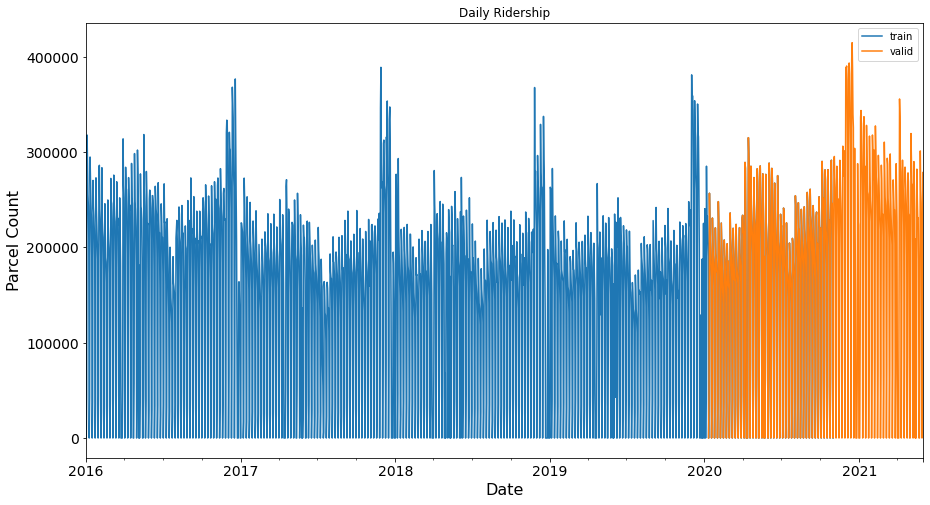

In [61]:
Train.parcels_rcv.plot(figsize =(15,8), title = "Daily Ridership", fontsize = 14, label = "train")
valid.parcels_rcv.plot(figsize =(15,8), title = "Daily Ridership", fontsize = 14, label = "valid")
plt.xlabel("Date", fontsize = 16)
plt.ylabel("Parcel Count", fontsize = 16)
plt.legend(loc ="best")
plt.show();

Here the blue part represents the train data and the orange part represents the validation data.

We will predict the traffic for the validation part and then visualize how accurate our predictions are. Finally we will make predictions for the test dataset.

# Modeling Techniques

We will look few models now to forecast the time series.
- __Naive Approach__ (based on last observed points in the time series)
- __Moving average__
- __Simple Exponential smoothing__

But there is still few modeling approach like Holt's linear, winter, ARIMA, SARIMAX etc, we will not go for that to make our project simple to understand data science modeling and prediction technique. 

## Naive Approach
- In this forecasting technique, we assume that the next expected point is equal to the last observed point. So we can expect a straight horizontal line as the prediction. 
suppose we have parcel count for 5 days are from day 1 to day 5 are 10,12,14,13,15 and we have to predict the parcel count for next two days, it means day 6 and 7, the prediction value will be 15 because Naive Approach will assign day 5 value to the nearest day 6&7.

__Lets make prediction using naive approach for the validation set__

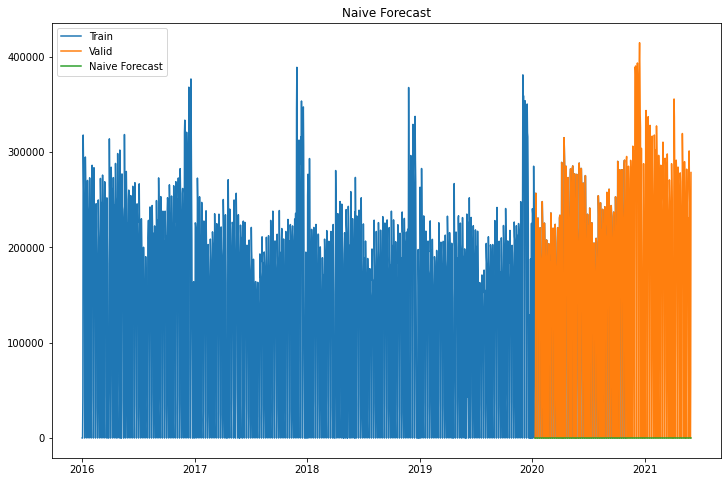

In [29]:
dd = np.asarray(Train.parcels_rcv)
y_hat = valid.copy()
y_hat["naive"] = dd[len(dd)-1]
plt.figure(figsize = (12,8))
plt.plot(Train.index, Train["parcels_rcv"], label = "Train")
plt.plot(valid.index, valid["parcels_rcv"], label = "Valid")
plt.plot(y_hat.index, y_hat["naive"], label = "Naive Forecast")
plt.legend(loc="best")
plt.title("Naive Forecast")
plt.show();

- we can calculate how accurate our predictions are using MSE
- MSE is the mean square deviation of the residuals.
- residuals area measure of how far from the regression line data points are
### we now calculate MSE to check the accuracy of our model on validation data set.


In [30]:
mse = mean_squared_error(valid.parcels_rcv, y_hat.naive)
print("Mean square error on the validation set: ",mse)
print("Average over all Mean square errors: ",mse/valid.size)

Mean square error on the validation set:  41884337482.19527
Average over all Mean square errors:  10326513.185945578


We can infer that this method is not suitable for datasets with high variability. we can reduce rmse value by adopting different techniques.

## Moving average
- In this technique we will take the average of the parcel counts for last few time periods only instead of taking all the previously known values.

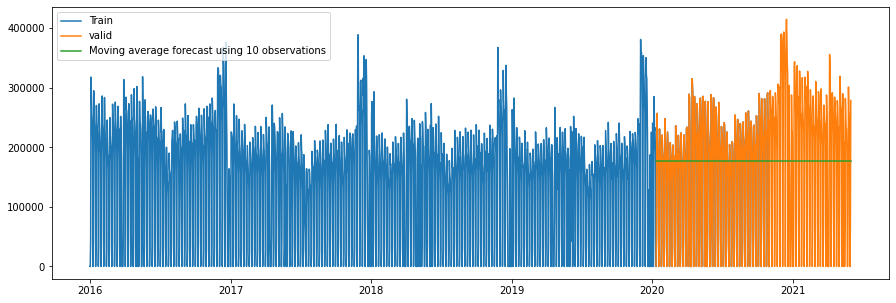

In [31]:
# taking last 10 observations 
yhat_avg = valid.copy()
yhat_avg["moving_avg_forecast"] = Train["parcels_rcv"].rolling(10).mean().iloc[-1] # Average of the last 10 observations
plt.figure(figsize = (15,5))
plt.plot(Train["parcels_rcv"], label = "Train")
plt.plot(valid["parcels_rcv"], label = "valid")
plt.plot(yhat_avg["moving_avg_forecast"], label = "Moving average forecast using 10 observations")
plt.legend(loc = "best")
plt.show();

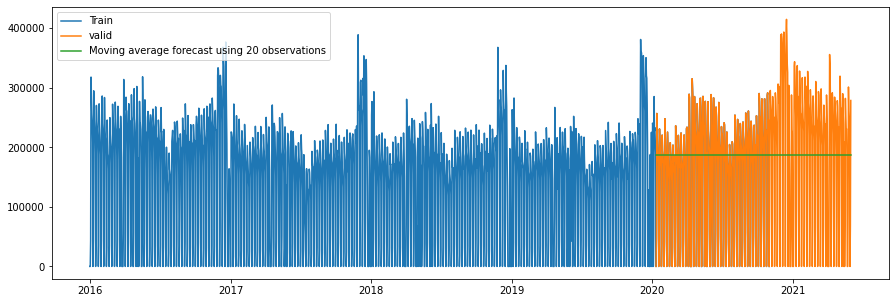

In [32]:
# taking last 20 observations 
yhat_avg = valid.copy()
yhat_avg["moving_avg_forecast"] = Train["parcels_rcv"].rolling(20).mean().iloc[-1] # Average of the last 10 observations
plt.figure(figsize = (15,5))
plt.plot(Train["parcels_rcv"], label = "Train")
plt.plot(valid["parcels_rcv"], label = "valid")
plt.plot(yhat_avg["moving_avg_forecast"], label = "Moving average forecast using 20 observations")
plt.legend(loc = "best")
plt.show();

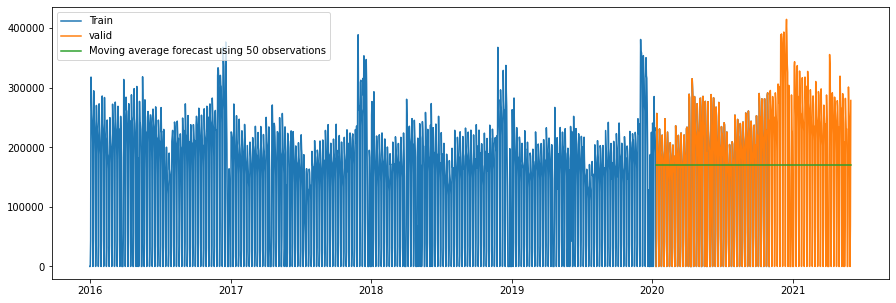

In [33]:
# taking last 50 observations 
yhat_avg = valid.copy()
yhat_avg["moving_avg_forecast"] = Train["parcels_rcv"].rolling(50).mean().iloc[-1] # Average of the last 10 observations
plt.figure(figsize = (15,5))
plt.plot(Train["parcels_rcv"], label = "Train")
plt.plot(valid["parcels_rcv"], label = "valid")
plt.plot(yhat_avg["moving_avg_forecast"], label = "Moving average forecast using 50 observations")
plt.legend(loc = "best")
plt.show();

We took the average of last 10,20, 50 observations and predicted based on that. This value can be changed in the above code in .rolling().mean() part.

In [34]:
mse = mean_squared_error(valid.parcels_rcv, yhat_avg.moving_avg_forecast)
print("Mean square error on the validation set: ",mse)
print("Average over all Mean square errors: ",mse/valid.size)

Mean square error on the validation set:  11755059715.593431
Average over all Mean square errors:  2898190.265185757


We can see that RMSE score is better for this model. 
We can infer that the fit of the model has improved as the rmse value has reduced.

## Simple Exponential smoothing
- In this technique, we design larger weights to more recent observations than to observations from the distant past.
- The weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

__NOTE__- If we give the entire weight to the last observed value only, this method will be similar to the naive approach. So, we can say that naive approach is also a simple exponential smoothing technique where the entire weight is given to the last observed value. 

Lets look at the example of simple exponential smoothing.

__Example__
Here the predictions are made by assigning larger weight to the current values and lesser weight to the old values.

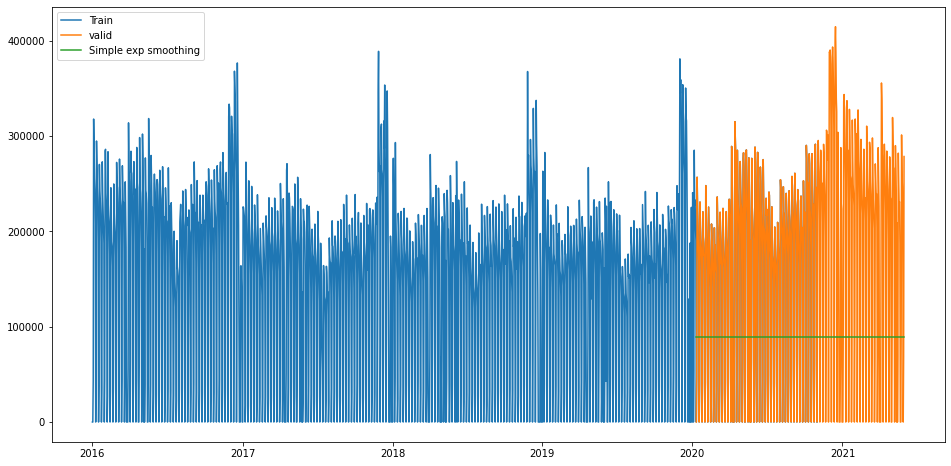

In [35]:
yhat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train["parcels_rcv"])).fit(smoothing_level = 0.6, optimized = False)
yhat_avg["SES"] = fit2.forecast(len(valid)) 
plt.figure(figsize = (16,8))
plt.plot(Train["parcels_rcv"], label = "Train")
plt.plot(valid["parcels_rcv"], label = "valid")
plt.plot(yhat_avg["SES"], label = "Simple exp smoothing")
plt.legend(loc = "best")
plt.show();

In [36]:
mse = mean_squared_error(valid.parcels_rcv, yhat_avg.SES)
print("Mean square error on the validation set: ",mse)
print("Average over all Mean square errors: ",mse/valid.size)

Mean square error on the validation set:  18797054899.826794
Average over all Mean square errors:  4634382.371752168


### Checking stationarity of the dataset

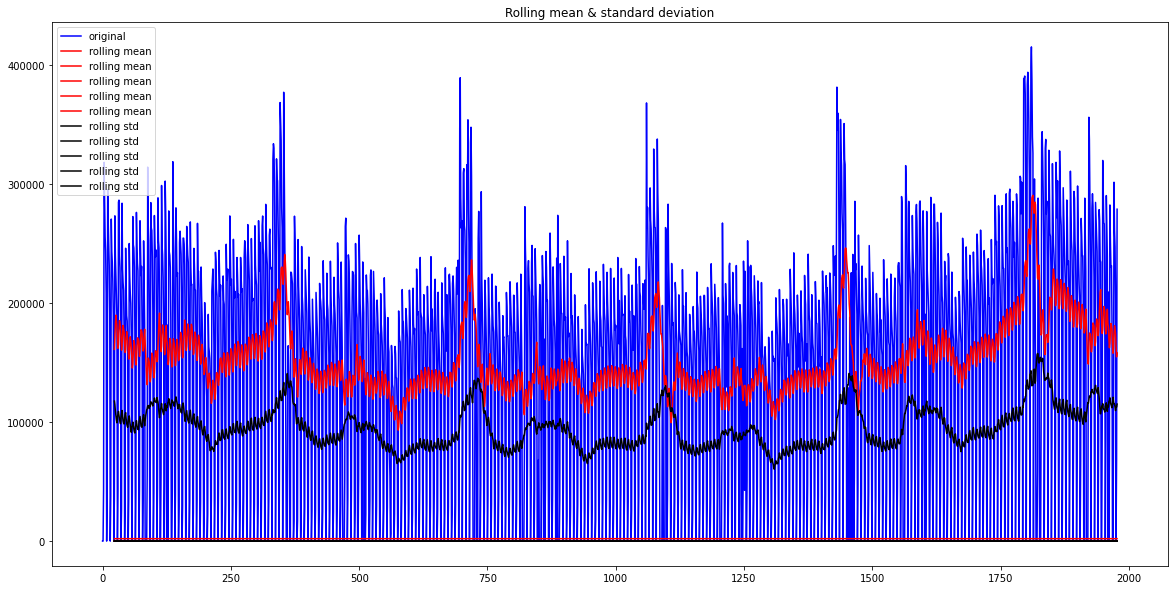

Results of dickey fuller test:
Test statistics              -6.151230e+00
p-value                       7.553754e-08
#Lags used                    2.100000e+01
Number of observation Used    1.956000e+03
critical value (1%)          -3.433698e+00
critical value (5%)          -2.863019e+00
critical value (10%)         -2.567557e+00
dtype: float64


In [37]:
def test_stationarity(timeseries):
    # Determine rolling statistics
    rolmean = train_original.rolling(24).mean()# 24 hrs on each day
    rolstd = train_original.rolling(24).std()
    # plot rolling statistics
    orig = plt.plot(timeseries, color ='blue', label = 'original')
    mean = plt.plot(rolmean, color ='red', label = 'rolling mean')
    std = plt.plot(rolstd, color ='black', label = 'rolling std')
    plt.legend(loc='best')
    plt.title("Rolling mean & standard deviation")
    plt.show(block = False)
    
    # perform Dickey fuller test:
    print("Results of dickey fuller test:")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test statistics', 'p-value', '#Lags used', 'Number of observation Used'])
    for key,value in dftest[4].items():
        dfoutput['critical value (%s)'%key]=value
    print(dfoutput)

test_stationarity(train_original['parcels_rcv']);

This statistics shows that the time series is stationary as Test statistics < critical value.


__Let's make prediction for the test dataset.__

So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

## SARIMAX model on daily time series
SARIMAX model takes into account the seasonality of the time series. So we will build a SARIMAX model on the time series. 

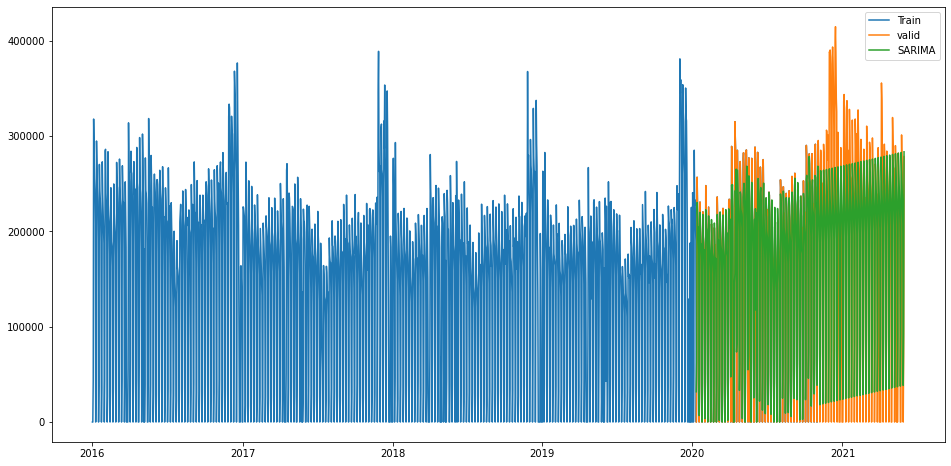

In [38]:
yhat_avg = valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(Train.parcels_rcv, order =(2,1,0), seasonal_order = (0,1,1,7),freq = "D").fit()
yhat_avg["SARIMA"] = fit1.predict(start = "01-11-2020", end = "31-05-2021", dynamic = False)
yhat_avg["SARIMA"] = yhat_avg["SARIMA"].clip(lower = 0)
plt.figure(figsize =(16,8))
plt.plot(Train["parcels_rcv"], label = "Train")
plt.plot(valid["parcels_rcv"], label = "valid")
plt.plot(yhat_avg["SARIMA"], label = "SARIMA")
plt.legend(loc ="best")
plt.show();

- Order in the above model represents the order of the autoregressive model(number of time lags), the degree of differencing(number of times the data have past values subtracted) and the order of moving average model.
- Seasonal order represents the order of the seasonal component of the model for the AR parameters, differences, MA parameters and periodicity.
- In our case periodicity is 7 since it is daily time series and will repeat after every 7 days.

Let's check the rmse value for the validation part.

In [39]:
mse = mean_squared_error(valid.parcels_rcv, yhat_avg.SARIMA.fillna(0))
print("Mean square error on the validation set: ",mse)
print("Average over all Mean square errors: ",mse/valid.size)

Mean square error on the validation set:  2611725589.745053
Average over all Mean square errors:  643916.5655189973


Now we wil forecast the time series for Test data which starts from 01-06-2021 and ends at 30-06-2021

In [40]:
predict = fit1.predict(begin = "01-06-2021", end ="30-06-2021", dynamic = False)
predict[predict<0]=0

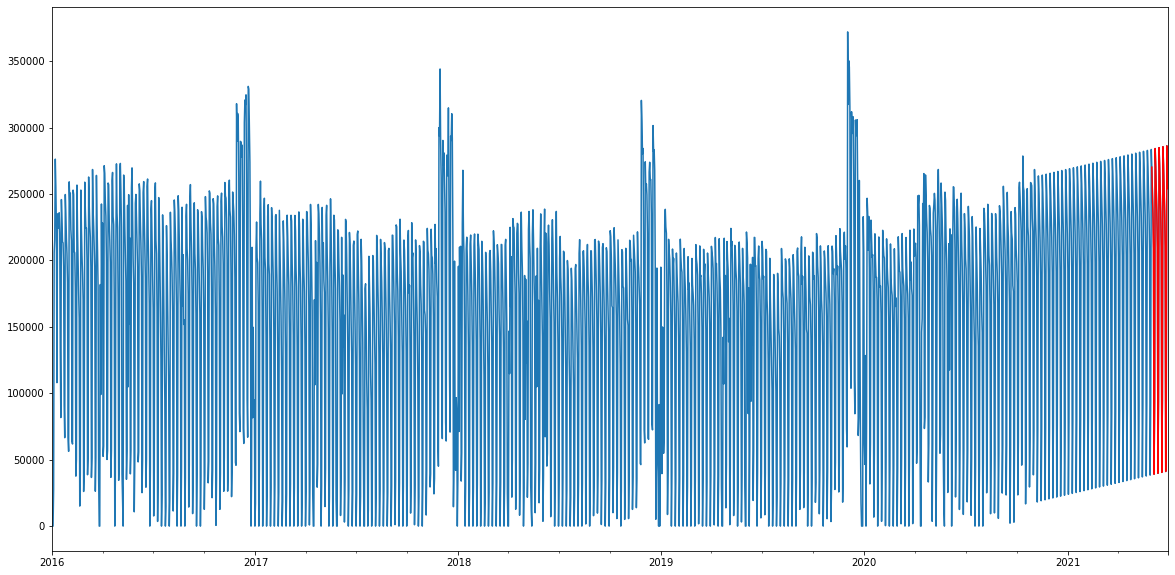

In [41]:
predict.plot()
predict[-30:].plot(color = "red");

__Here I used whole data as training set and predict the test data.__

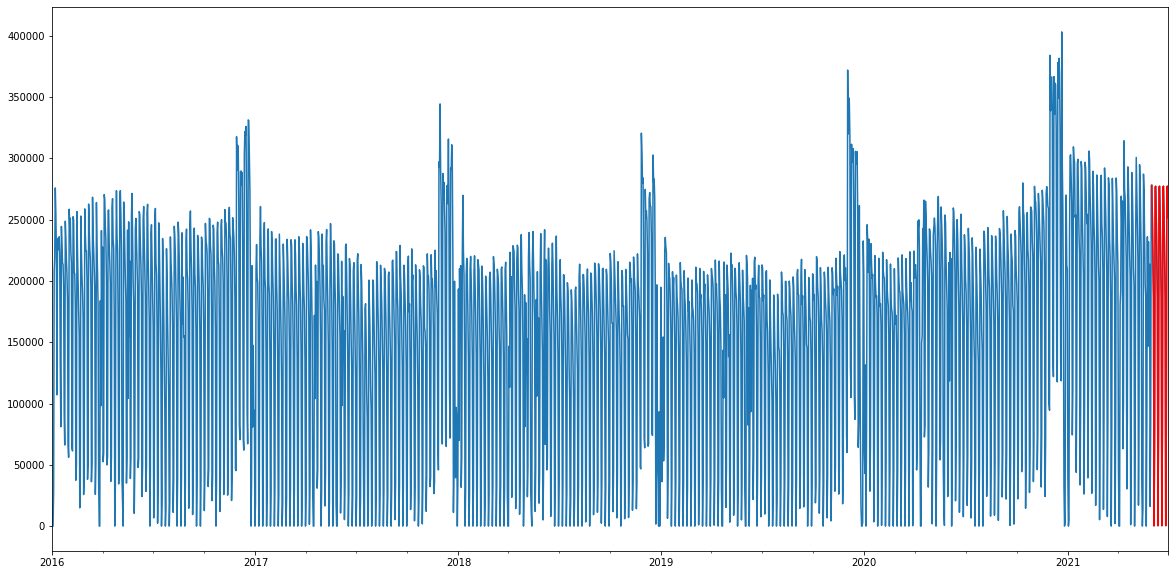

In [42]:
fit2 = sm.tsa.statespace.SARIMAX(train.parcels_rcv, order =(2,1,0), seasonal_order = (0,1,1,7),freq = "D").fit()
predict1 = fit2.predict(begin = "01-06-2021", end ="30-06-2021", dynamic = False)
predict1[predict1<0]=0
predict1.plot()
predict1[-30:].plot(color = "red");

<AxesSubplot:>

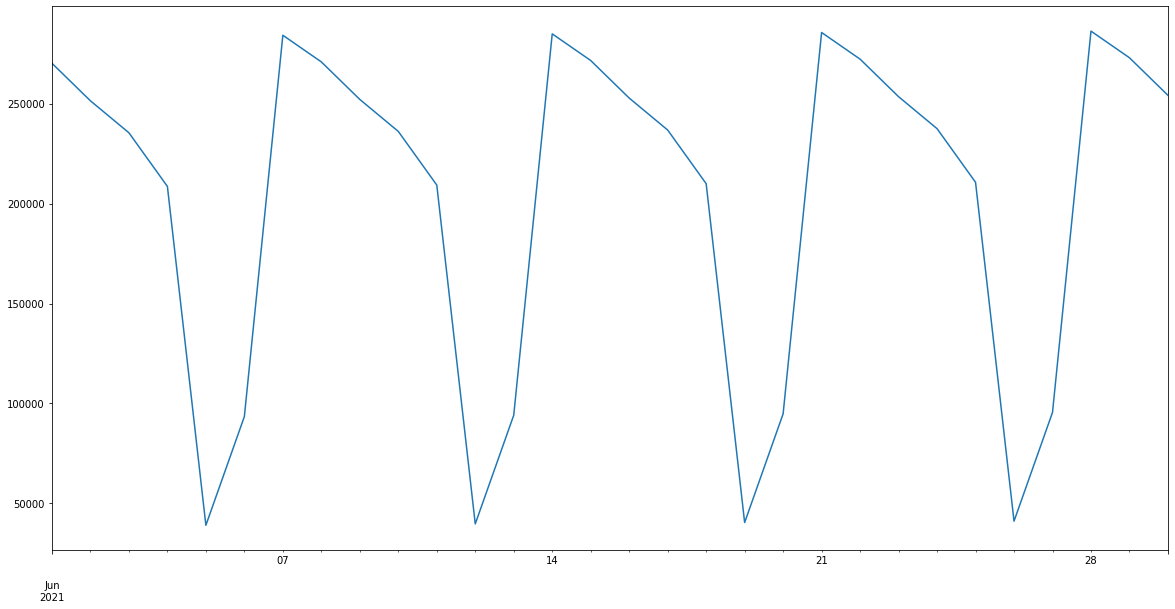

In [43]:
predict[-30:].plot()

# Conclusion
I tried with first simple base model. Then I tried with Moving average and exponential smoothing models. Though many other models could have been tried, I stuck to these two models based on my previous data exploration and hypothesis testing. Lastly based on my conclusions on these models I used SARIMAX model which performs the best.
For all the models firstly I have checked by creating training and validation sets(performance metric based on validation set). Upon confirming the final model(SARIMAX) I have used the test data for prediction. 

__Note__ I have not performed hyperparameter tuning but I believe that with hyperparameter optimization much better performance metrics could have been obtained with the model that I have specified.
